#**Atividade de Aprendizagem de Máquina - Missão 8**

Discentes:  Cynthia Moreira Maia, Lucas Benevides Viana de Amorim e Sara Bandeira Coutinho

Docente: Dr. Leandro Maciel Almeida

**Atividade:** Realizar experimento com a implementação de comitês bagging, boosting e stacking para base de dados do Glass. Os modelos base para formação do comitê poderão ser KNN, SVM, Árvore de Decisão e/ou Redes Neurais Artificiais. Realizar uma busca de tal modo que os comitês apresentem desempenho superior ao desempenho solo dos classificadores. Apresentar análise, os principais desafios encontrados para a construção dos comitês e conclusões.

###**Introdução**

Os comitês de classificadores são sistemas de classificação compostos por um conjunto de classificadores e por um método responsável pela combinação dos resultados. Os comitês têm como objetivo melhorar o desempenho na classificação dos dados, por meio da integração dos resultados dos classificadores para que ao final se tenha um resultado final mais acurado [1]. O método de combinação reune os resultados dos classificadores base em uma resposta final que corresponde à saída do comitê [2]. De acordo com Kuncheva (2004) [1], os métodos de combinação podem ser categorizados em duas estratégias principais: fusão e seleção. São exemplos de métodos de seleção, o comitê Bagging [3] e Boosting [4], que são métodos com preditores homogêneos. No Bagging, é feito com os preditores homogêneos de forma independente e paralela em relação ao outro. O resultado final, é de acordo com o resultado médio do que foi obtido a partir dos preditores. No Boosting, os preditores são aplicados de forma sequencial, no qual, o posterior depende do antecessor e depois são combinados no modelo final [5].

Já na fusão, a saída final é construída baseada em resultados coletivos, ou seja, nas decisões de todos os preditores heterogêneos para que ao final se tenha uma decisão final, treinando-os em paralelo. São exemplos de métodos de fusão, o comitê Stacking [6]. O Stacking combina as saídas dos classificadores base por meio de um meta classificador para uma predição final, do qual se espera um melhor desempenho. 

Este relatório tem por objetivo apresentar uma comparação do desempenho de classificadores individuais (Árvore de Decisão e KNN) e da combinação de classificadores (Bagging, Boosting e Stacking), no conjunto de dados, Glass, oriundo do repositório da UCI. O problema analisado é de classificação, no qual, contém: 6 classes, 10 atributos (no total) e 214 instâncias. O objetivo consiste em classificar os tipos de vidros a partir de informações como: índice de refração, quantidades de alumínio, silício, magnésio e outros elementos químicos.


## **Experimento**

Para este experimento, os algoritmos foram implementados na ferramenta Colab, com uso da linguagem Python. O pacote principal utilizado foi o sklearn. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
#from sklearn.impute import SimpleImputer
#from sklearn_pandas import CategoricalImputer
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier # decision tree
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.neighbors import KNeighborsClassifier # knn
from sklearn.svm import SVC # svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from imblearn.metrics import geometric_mean_score
from copy import copy
import warnings
import random

In [ ]:
# Carregamento dos dados:
cols = ['id','RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'class']
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data", header=None, names=cols)
df = df.drop(['id'], axis = 1)
df

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,class
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


Este conjunto de dados consiste de valores relativos às proporções de diferentes elementos químos em amostras de vidro. O objetivo é determinar o tipo de vidro (atributo alvo) de uma determinada amostra entre os seguintes:

      -- 1 building_windows_float_processed
      -- 2 building_windows_non_float_processed
      -- 3 vehicle_windows_float_processed
      -- 5 containers
      -- 6 tableware
      -- 7 headlamps

A identificação do tipo (e/ou origem) dos fragmentos de vidro tem motivação no campo das investigações criminais, já que, em uma cena de crime, estes fragmentos podem ser usados como evidência se corretamente identificados.

###**Análise Exploratória dos Dados**


Como primeira etapa do estudo, realizamos uma análise exploratória dos dados com o objetivo de conhecer as principais características do conjunto de dados, como os tipos dos atributos, se há valores faltosos e a correlação entre os atributos e com o atributo alvo (classe). Conforme os resultados obtidos, todos os atributos são numéricos e contínuos, não havendo valores faltosos, corroborando com a descrição dos dados presente no repositório. Três atributos apresentam uma correlação média com o atributo alvo, que é: Na (Sódio), Al (Alumínio) e Ba (Bário). Estes atributos, são portanto, mais importantes para o processo preditivo. Em outras palavras, estes três elementos químicos são decisivos para a determinação das propriedades físicas do vidro que lhe conferem a possibilidade de uso nas suas diferentes aplicações. E foi constatado que em nenhuma das colunas se tem alto grau de correlação, não prejudicando a importância dos atributos.

In [ ]:
#verificar se tem dados faltosos
df.isnull().sum()

RI       0
Na       0
Mg       0
Al       0
Si       0
K        0
Ca       0
Ba       0
Fe       0
class    0
dtype: int64

In [ ]:
#correlação
df.corr()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,class
RI,1.000000,-0.191885,-0.122274,-0.407326,-0.542052,-0.289833,0.810403,-0.000386,0.143010,-0.164237
Na,-0.191885,1.000000,-0.273732,0.156794,-0.069809,-0.266087,-0.275442,0.326603,-0.241346,0.502898
Mg,-0.122274,-0.273732,1.000000,-0.481799,-0.165927,0.005396,-0.443750,-0.492262,0.083060,-0.744993
Al,-0.407326,0.156794,-0.481799,1.000000,-0.005524,0.325958,-0.259592,0.479404,-0.074402,0.598829
Si,-0.542052,-0.069809,-0.165927,-0.005524,1.000000,-0.193331,-0.208732,-0.102151,-0.094201,0.151565
K,-0.289833,-0.266087,0.005396,0.325958,-0.193331,1.000000,-0.317836,-0.042618,-0.007719,-0.010054
Ca,0.810403,-0.275442,-0.443750,-0.259592,-0.208732,-0.317836,1.000000,-0.112841,0.124968,0.000952
Ba,-0.000386,0.326603,-0.492262,0.479404,-0.102151,-0.042618,-0.112841,1.000000,-0.058692,0.575161
Fe,0.143010,-0.241346,0.083060,-0.074402,-0.094201,-0.007719,0.124968,-0.058692,1.000000,-0.188278
class,-0.164237,0.502898,-0.744993,0.598829,0.151565,-0.010054,0.000952,0.575161,-0.188278,1.000000


In [ ]:
# Separando X e y:
X = df[df.columns[:-1]].to_numpy()
y = df[df.columns[[-1]]].to_numpy().ravel()

####**Pré-Processamento**

As técnicas de pré-processamento visam modificar os dados de entrada para um formato que seja possível realizar análises com um melhor desempenho, que melhorem a qualidade dos dados [6]. Foi verificado o desbalanceamento das classes, no qual, constatou-se que o número de instâncias por classe varia bastante [9,76]. E a partir disso, foi aplicado o SMOTE para realizar o balanceamento das classes, em que criou instâncias sintéticas das classes minoritárias, cada classe ficou com 76 instâncias. Outro fator observado, foi que os atributos estavam em escalas bem diferentes, conforme visto da etapa de análise exploratória. Isso justificou a aplicação de uma técnica de normalização para que ficassem na mesma escala. Adotou-se o min-max, que consiste em colocar os valores numa escala de [0,1]. Para isso, seu cálculo se baseia na função que divide o valor em questão subtraído do menor valor existente e divide esse resultado pela subtração do maior menos o menor valores existentes [7]. Com isso, a escala passa a ser um valor percentual e decimal menor que um. 

In [ ]:
# Contagem de instâncias por classe:
Counter(df['class'])

Counter({1: 70, 2: 76, 3: 17, 5: 13, 6: 9, 7: 29})

In [ ]:
X, y = SMOTE().fit_resample(X, y)
Counter(y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.2

Counter({1: 76, 2: 76, 3: 76, 5: 76, 6: 76, 7: 76})

In [ ]:
# Separando os 5 folds para validação cruzada repetida 2 vezes:
rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=0)
X_train_folds = []
y_train_folds = []
X_test_folds = []
y_test_folds = []
for train_index, test_index in rkf.split(X):
  X_train_folds.append(X[train_index])
  X_test_folds.append(X[test_index])
  y_train_folds.append(y[train_index])
  y_test_folds.append(y[test_index])


In [ ]:
# Normalização com min-max
mm = MinMaxScaler()
for i in range(len(X_train_folds)):
    X_train_folds[i] = mm.fit_transform(X_train_folds[i])
    X_test_folds[i] = mm.transform(X_test_folds[i])

In [ ]:
def validacao_cruzada(model):
  cv_results = {'test_accuracy':[]}
  for fold in range(len(X_train_folds)):
      X_train = X_train_folds[fold]
      y_train = y_train_folds[fold]
      X_test = X_test_folds[fold]
      y_test = y_test_folds[fold]
      #print('Contagem de classes:\nTreino = ', Counter(y_train), '\nTeste: ', Counter(y_test))

      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)

      test_acc = accuracy_score(y_test, y_pred)
      cv_results['test_accuracy'].append(test_acc)
      test_precision = precision_score(y_test, y_pred)
      cv_results['test_precision'].append(test_precision)
      test_f1 = f1_score(y_test, y_pred)
      cv_results['test_f1'].append(test_f1)
  return cv_results

###**Grid Search**

Com o objetivo de estabelecer as melhores escolhas de parâmetros adotados em cada algoritmo de classificação, realizou-se o tuning dos hiperparâmetros por meio da técnica de busca em grade (GridSearch). Para tanto, foi utilizado o pacote *GridSearchCV*.  Os dados foram divididos, de tal forma, que uma parte dos dados de treinamento fossem utilizados para validação e ajustes dos hiperparâmetros. 

In [ ]:
# Separando um conjunto de validação para o GridSearch
X_train_all = np.concatenate(X_train_folds)
y_train_all = np.concatenate(y_train_folds)
rest_X , val_x, rest_y , val_y = train_test_split(X_train_all, y_train_all, test_size=0.2)

####**i) Árvore de Decisão**

Foi utilizado o pacote do *sklearn* para implementação de um modelo de árvore de decisão. O ajuste fino compreendeu os seguintes parâmetros: profundidade máxima da árvore e o critério de decisão.

In [ ]:
decisiontree = DecisionTreeClassifier()
criterion = ['gini', 'entropy']
max_depth = [2,3,4,6]
parameters = dict(criterion=criterion,max_depth=max_depth)
dt = GridSearchCV(decisiontree, parameters)
dt.fit(val_x, val_y)
print('Os melhores parâmetros foram:', dt.best_params_)
best_params_criterion = dt.best_params_['criterion']
best_params_max_depth = dt.best_params_['max_depth']

Os melhores parâmetros foram: {'criterion': 'entropy', 'max_depth': 6}


####**ii) K-NN**

Foi utilizado o pacote do *sklearn* para implementação do algoritmo kNN, o qual está baseado na distância do novo dado considerando-se os k vizinhos. Verificou-se, no ajuste de hiperparâmetros, os melhores valores para *k* e qual a melhor métrica de distância.


In [ ]:
classifier = KNeighborsClassifier()
k_list = list(range(2,31))
metric = ['euclidean','minkowski']
param_grid= dict(n_neighbors=k_list, metric=metric)
knn = GridSearchCV(classifier, param_grid)
knn.fit(val_x, val_y)
print('Os melhores parâmetros foram:', knn.best_params_)
best_n = knn.best_params_['n_neighbors']
best_metric = knn.best_params_['metric']

Os melhores parâmetros foram: {'metric': 'euclidean', 'n_neighbors': 2}


###**Definindo Funções Auxiliares**

As métricas escolhidas para avaliar a performance de classificação neste estudo são: acurácia (acc), F-Measure (F1), G-mean, precisão (precision) e cobertura (recall).
 
A métrica da acurácia considera o percentual de acertos dentro do conjunto de dados que está sendo avaliado. A precisão é traduzida pela divisão da quantidade de classificações feitas corretamente pelo total de tentativas que foram positivas. A cobertura corresponde a sensibilidade que é dada pela divisão de casos positivos sobre o total de positivos.
A métrica F-Measure envolve tanto a cobertura quanto a precisão, fazendo uma média geométrica entre as duas. 
A G-mean, por sua vez, pode ser obtida através do cálculo da média geométrica entre as taxas de verdadeiros positivos e de verdadeiros negativos, simbolizando o desempenho do classificador com relação às taxas de acertos das classes. A função abaixo (cros_val) realiza a validação cruzada e calcula as métricas supracitadas para cada fold, armazenado-as em um dicionário que é retornado para posterior análise.


In [ ]:
def cros_val(X_train_folds, y_train_folds, X_test_folds, y_test_folds, models):
    metrics = {'acc':{}, 'f1':{}, 'gmean':{}, 'precision':{}, 'recall':{}}
    #Validação cruzada
    for name, model in models.items():
        print(f'\nModelo {name}: ')
        acc_folds = []
        f1_folds = []
        gmean_folds = []
        precision_folds = []
        recall_folds = []
        for i in range(len(X_train_folds)):
            print('.',end='')
            model.fit(X_train_folds[i], y_train_folds[i])
            y_pred = model.predict(X_test_folds[i])
            y_true = y_test_folds[i]
            #Calculando as métricas:
            acc_folds.append(accuracy_score(y_true, y_pred))
            f1_folds.append(f1_score(y_true, y_pred, average='macro'))
            gmean_folds.append(geometric_mean_score(y_true, y_pred, average='macro'))
            precision_folds.append(precision_score(y_true, y_pred, average='macro', zero_division=0))
            recall_folds.append(recall_score(y_true, y_pred, average='macro'))
        metrics['acc'][name] = acc_folds
        metrics['f1'][name] = f1_folds
        metrics['gmean'][name] = gmean_folds
        metrics['precision'][name] = precision_folds
        metrics['recall'][name] = recall_folds
    return metrics

### **Classificadores monolíticos**



Como dito na introdução do relatório, deseja-se realizar uma comparação do desempenho dos classificadores individuais e da combinação dos classificadores. Dessa forma, são  apresentados a seguir os desempenhos dos classificadores de maneira individual. 

#### **Definição dos modelos**


In [ ]:
mono_models = {'DT':DecisionTreeClassifier(criterion=best_params_criterion, max_depth=best_params_max_depth, random_state=0),
               'KNN': KNeighborsClassifier(n_neighbors=best_n, metric=best_metric, n_jobs=-1)
              }

#### **Validação cruzada e Métricas de Desempenho**

In [ ]:
#warnings.filterwarnings(action="ignore")
warnings.filterwarnings(action="default")
metrics_mono = cros_val(X_train_folds, y_train_folds, X_test_folds, y_test_folds, mono_models)


Modelo DT: 
..........
Modelo KNN: 
..........

In [ ]:
print('Média das métricas para os modelos:')
for name in list(mono_models.keys()):
    print(f'*** Modelo {name} ***')
    print('Acurácia = ', np.mean(metrics_mono['acc'][name]))
    print('F1 = ', np.mean(metrics_mono['f1'][name]))
    print('G-Mean = ', np.mean(metrics_mono['gmean'][name]))
    print('Precision = ', np.mean(metrics_mono['precision'][name]))
    print('Recall = ', np.mean(metrics_mono['recall'][name]))

Média das métricas para os modelos:
*** Modelo DT ***
Acurácia =  0.8322145246058289
F1 =  0.83194583598706
G-Mean =  0.8994981795109546
Precision =  0.8422038676059236
Recall =  0.8373568242753194
*** Modelo KNN ***
Acurácia =  0.8454610606784521
F1 =  0.8432168365719459
G-Mean =  0.9069585554078834
Precision =  0.8551630772286589
Recall =  0.8490593255388316


### **Comitês de Classificadores**

Aqui são apresentados os desempenhos da combinação dos classificadores, por meio dos métodos: Bagging, Boosting e Stacking.

#### **Definição dos modelos**



In [ ]:
# Construindo classificadores base:
dt_clf = DecisionTreeClassifier(criterion=best_params_criterion, max_depth=best_params_max_depth, random_state=0)
knn_clf = KNeighborsClassifier(n_neighbors=best_n, metric=best_metric, n_jobs=-1)

#### **Bagging**

Foi utilizado o pacote do *sklearn* para implementação do Bagging. Obteve-se um modelo considerando como preditores homogêneos a árvore de decisão e outro modelo considerando o KNN.

In [ ]:
bag_dt_clf = BaggingClassifier(base_estimator=dt_clf, n_estimators=100, n_jobs=-1)
bag_knn_clf = BaggingClassifier(base_estimator=knn_clf, n_estimators=100, n_jobs=-1)

#### **Boosting**

Foi utilizado o pacote do *sklearn* para implementação do Boosting, no qual, utilizou-se o algoritmo: Adaboost. Obteve-se um comitê considerando como preditores homogêneos a árvore de decisão. Não foi possível obter um comitê com o KNN como modelo base pois o KNN não suporta ponderação de amostras, algo que é fundamental para o funcionamento de uma algoritmo de Boosting.

In [ ]:
adaboost_dt_clf = AdaBoostClassifier(base_estimator=dt_clf, n_estimators=100)
#Para o adaboost, usamos somente as DTs, pois não é possível aplicar boosting ao KNN, já que não suporta sample_weight

#### **Stacking**

Foi utilizado o pacote do *sklearn* para implementação do Stacking. Como meta-classificador fez uso da regressão logística. Obteve-se um comitê homogêneo com uso de árvore de decisão como modelo base, outro homogêneo com uso do KNN como base e um comitê híbrido, composto por 50% de modelos de árvores de decisão e 50% de modelos KNN. 

In [ ]:
# A classe StackingClassifier pede que passemos os classificadores que irão compor o pool em tuplas com os nomes. 
# Para realizarmos uma comparação justa, utilizaremos o mesmo pool gerado pelo bagging.
# Para isso, precisamos dar o fit() no Bagging para que sejam criados os 100 estimadores. 
# Durante a cros_val, o fit será refeito com os folds.

bag_dt_clf.fit(X,y)
bag_knn_clf.fit(X,y);

bag_dt_named_pool = {(f'dt_{i}', bag_dt_clf.estimators_[i]) for i in range(bag_dt_clf.n_estimators)}
bag_knn_named_pool = {(f'knn_{i}', bag_knn_clf.estimators_[i]) for i in range(bag_knn_clf.n_estimators)}

#Construindo um pool híbrido:
bag_hib_named_pool = random.sample(bag_dt_named_pool, int(0.5*bag_dt_clf.n_estimators)) + random.sample(bag_knn_named_pool, int(0.5*bag_knn_clf.n_estimators))

lr = LogisticRegression(max_iter=200, tol=1e-3, n_jobs=-1)
stack_dt_clf = StackingClassifier(estimators=bag_dt_named_pool, final_estimator=lr, n_jobs=-1)
stack_knn_clf = StackingClassifier(estimators=bag_knn_named_pool, final_estimator=lr, n_jobs=-1)
stack_hib_clf = StackingClassifier(estimators=bag_hib_named_pool, final_estimator=lr, n_jobs=-1)

In [ ]:
ens_models = {'Bagging - DT': bag_dt_clf,
              'Bagging - KNN': bag_knn_clf,
              'AdaBoost - DT': adaboost_dt_clf, 
              'Stacking - DT': stack_dt_clf,
              'Stacking - KNN': stack_knn_clf,
              'Stacking - Híbrido': stack_hib_clf
             }

#### **Validação cruzada e Métricas de Desempenho**

In [ ]:
metrics_ens = cros_val(X_train_folds, y_train_folds, X_test_folds, y_test_folds, ens_models)


Modelo Bagging - DT: 
..........
Modelo Bagging - KNN: 
..........
Modelo AdaBoost - DT: 
..........
Modelo Stacking - DT: 
..........
Modelo Stacking - KNN: 
..........
Modelo Stacking - Híbrido: 
..........

In [ ]:
print('Média das métricas para os modelos de ensemble:')
for name in list(ens_models.keys()):
    print(f'*** Modelo {name} ***')
    print('Acurácia = ', np.mean(metrics_ens['acc'][name]))
    print('F1 = ', np.mean(metrics_ens['f1'][name]))
    print('G-Mean = ', np.mean(metrics_ens['gmean'][name]))
    print('Precision = ', np.mean(metrics_ens['precision'][name]))
    print('Recall = ', np.mean(metrics_ens['recall'][name]))

### **Resultados e Discussões**

A seguir são apresentadas, em um gráfico de barras, a performance dos classificadores em termos das métricas avaliadas.
 

In [ ]:
def plot_metrics(metrics):
    labels = list(metrics['acc'].keys()) #Nomes dos modelos
    
    acc_means = [np.mean(l) for l in list(metrics['acc'].values())]
    f1_means = [np.mean(l) for l in list(metrics['f1'].values())]
    gmean_means = [np.mean(l) for l in list(metrics['gmean'].values())]
    prec_means = [np.mean(l) for l in list(metrics['precision'].values())]
    rec_means = [np.mean(l) for l in list(metrics['recall'].values())]
   
    x = np.arange(len(labels)) # Os locais dos labels no eixo x
    width = 0.16 # largura das barras
    fig, ax = plt.subplots(figsize=(16,10))
    #TODO: Consertar posições das barras!
    rects_acc = ax.bar(x - 2*width, acc_means, width, label='Acurácia')
    rects_precision = ax.bar(x - width, prec_means, width, label='Precisão')
    rects_recall = ax.bar(x , rec_means, width, label='Cobertura')
    rects_f1 = ax.bar(x  + width, f1_means, width, label='F-measure')
    rects_gmean = ax.bar(x + 2*width, gmean_means, width, label='G-Mean')
    ax.set_ylabel('Performance')
    #ax.set_title('Performance por modelo')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim([0,1])
    plt.grid(True)
    ax.legend()

#### Gráficos de Barras

Os gráficos abaixo mostram as médias das métricas para cada modelo.

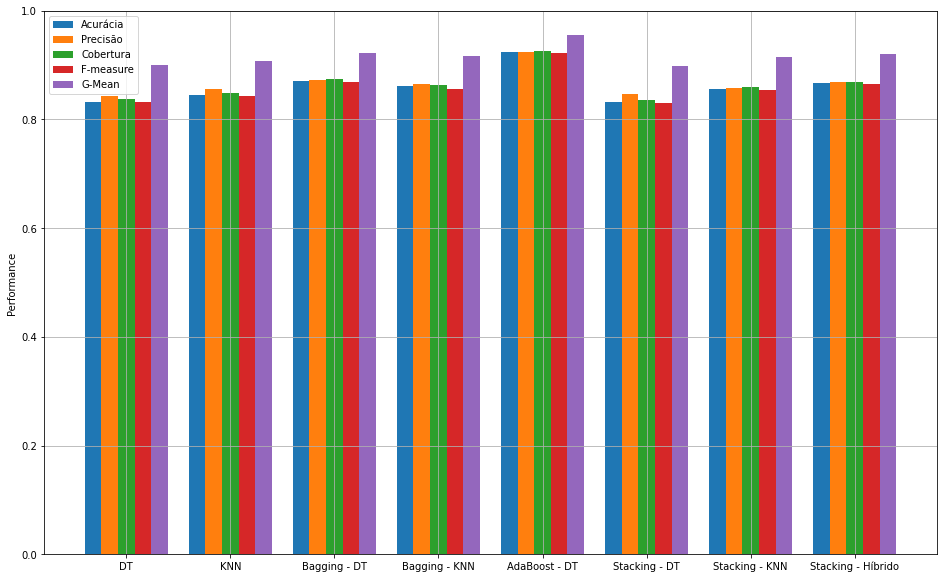

In [ ]:
# Juntando as métricas dos modelos mono e ensemble para um único plot:
metrics_all = {}
for m in list(metrics_mono.keys()):
  metrics_all[m] = copy(metrics_mono[m])
  metrics_all[m].update(metrics_ens[m])

plot_metrics(metrics_all)


In [ ]:
import plotly.graph_objects as go
categories = ['DT','KNN','Bagging - DT', 'Bagging - KNN', 'AdaBoost - DT','Stacking - DT',
              'Stacking - KNN','Stacking - Híbrido']

acc_means = [np.mean(l) for l in list(metrics_all['acc'].values())]
f1_means = [np.mean(l) for l in list(metrics_all['f1'].values())]
gmean_means = [np.mean(l) for l in list(metrics_all['gmean'].values())]
prec_means = [np.mean(l) for l in list(metrics_all['precision'].values())]
rec_means = [np.mean(l) for l in list(metrics_all['recall'].values())]

fig = go.Figure()
fig.add_trace(go.Scatterpolar(r=acc_means,theta=categories,fill='toself',name='Acurácia'))
fig.add_trace(go.Scatterpolar(r=f1_means,theta=categories,fill='toself',name='F-Measure'))
fig.add_trace(go.Scatterpolar(r=gmean_means, theta=categories,fill='toself',name='G-Mean'))
fig.add_trace(go.Scatterpolar(r=prec_means,theta=categories,fill='toself',name='Precisão'))
fig.add_trace(go.Scatterpolar(r=rec_means, theta=categories,fill='toself',name='Cobertura')),
fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0.82, 1])),showlegend=False)

fig.show()

Observando os dois gráficos acima, destacamos os seguintes pontos:

*   O Melhor comitê, considerando as cinco métricas, foi aquele construído com o AdaBoost tendo como modelos base as árvores de decisão (DT). 
*   Para os ensembles construídos com Bagging, o melhor modelo base, para todas as métricas, foi o de árvore de decisão (DT). Este achado explica-se pelo fato destes modelos de árvore de decisão terem mais alta variância e serem altamente sensíveis a mudanças nos dados apresentados (tal qual as subamostragens feitas no Bagging) sendo portanto considerados aprendizes fracos, o que possibilita a construção de um pool com alta diversidade. 
*   Também para todas as métricas, os modelos de ensemble com Bagging e Adaboost superaram os dois modelos monolíticos DT e KNN. Somente o modelo de ensemble com Stacking e DT como modelo base apresentou métricas inferiores aos modelos monolíticos.
*   Para o caso do algoritmo de Stacking, a construção de um pool híbrido permitiu o aumento da performance se comparado ao mesmo algoritmo quando considerado os pools homogêneos (DT ou KNN), indicando que este algoritmo funciona melhor com pools heterogêneos.


É salutar no entanto que seja verificada a significância estatística dessas diferenças. Na seção seguinte realizaremos um teste de hipótese com este fim.




#### Teste de Hipótese

Para a realizaçao desta etapa, foi necessario que antes fosse feito um teste de aderência de forma a identificar se o comportamento dos dados se assemelhava a uma distribuiçao normal. Foi aplicado o teste de Shapiro-Wilk. Em seguida, mediante o resultado do teste, seguiu-se com o teste de hipotese. Foram consideradas as seguintes hipóteses:

$𝐻_0$  - Não há diferença significativa entre a perfomance dos modelos monolíticos e os modelos de ensemble.

$𝐻_1$  - Há diferença significativa entre a perfomance dos modelos monolíticos e os modelos de ensemble.



In [ ]:
# Primeiramente é necessário realizar um teste de aderência, para vericar a normalidade dos dados:
import scipy.stats as stats
# Teste de normalidade 
def teste_shapiro(data):
  shapiro_stat, shapiro_p_valor=stats.shapiro(data)
  #print('O valor da estatistica de Shapiro-Wilk =%.3f, O valor de p de Shapiro-Wilk=%.3f' % (shapiro_stat, shapiro_p_valor))
  alpha = 0.05
  return shapiro_p_valor <= alpha

for model in list(metrics_all['acc'].keys()): #Nome dos modelos
  print(f'\n** {model} **')
  nenhum_rejeita = True
  for metric in ['acc', 'recall','precision', 'f1', 'gmean']:
    #print(f'- Métrica: {metric}')
    if teste_shapiro(metrics_all[metric][model]):
      print(f'A amostra do modelo {model} com a métrica {metric} não se assemelha a uma Gaussiana (rejeita H0)')
      nenhum_rejeita = False
  if nenhum_rejeita: print('Para este modelo todas as amostras se assemelham a uma Gaussiana (não rejeitam H0)')
    


** DT **
Para este modelo todas as amostras se assemelham a uma Gaussiana (não rejeitam H0)

** KNN **
Para este modelo todas as amostras se assemelham a uma Gaussiana (não rejeitam H0)

** Bagging - DT **
Para este modelo todas as amostras se assemelham a uma Gaussiana (não rejeitam H0)

** Bagging - KNN **
Para este modelo todas as amostras se assemelham a uma Gaussiana (não rejeitam H0)

** AdaBoost - DT **
Para este modelo todas as amostras se assemelham a uma Gaussiana (não rejeitam H0)

** Stacking - DT **
A amostra do modelo Stacking - DT com a métrica precision não se assemelha a uma Gaussiana (rejeita H0)

** Stacking - KNN **
A amostra do modelo Stacking - KNN com a métrica acc não se assemelha a uma Gaussiana (rejeita H0)
A amostra do modelo Stacking - KNN com a métrica precision não se assemelha a uma Gaussiana (rejeita H0)

** Stacking - Híbrido **
Para este modelo todas as amostras se assemelham a uma Gaussiana (não rejeitam H0)


Como no resultado do teste, nem todas as amostras apresentam uma distribuição normal, portanto adotou-se como teste de hipótese não paramétrico. Foi aplicado o teste *Wilcoxon* para verificar o desempenho dos classificadores.

In [ ]:
# Teste de Hipotese 
def teste_w(x1, x2):
  from scipy.stats import wilcoxon
  stat, p = wilcoxon(x1, x2) 
  print('O valor da estatistica =%.3f,  O valor de p =%.3f' % (stat, p))
  if p > 0.05: 
        print('A diferença entre as médias das métricas não é estatisticamente significante (não rejeita H0)')
  else:
        print('A diferença entre as médias das métricas é estatisticamente significante (rejeita H0)')

In [ ]:
for model_mono in list(mono_models.keys()):
  for model_ens in list(ens_models.keys()): #Nome dos modelos
    print(f'\n** Comparando {model_mono} vs. {model_ens} **')
    for metric in ['acc', 'recall','precision', 'f1', 'gmean']:
      print(f'- Métrica: {metric}')
      teste_w(metrics_mono[metric][model_mono], metrics_ens[metric][model_ens])


** Comparando DT vs. Bagging - DT **
- Métrica: acc
O valor da estatistica =0.000,  O valor de p =0.005
A diferença entre as médias das métricas é estatisticamente significante (rejeita H0)
- Métrica: recall
O valor da estatistica =0.000,  O valor de p =0.005
A diferença entre as médias das métricas é estatisticamente significante (rejeita H0)
- Métrica: precision
O valor da estatistica =2.000,  O valor de p =0.009
A diferença entre as médias das métricas é estatisticamente significante (rejeita H0)
- Métrica: f1
O valor da estatistica =0.000,  O valor de p =0.005
A diferença entre as médias das métricas é estatisticamente significante (rejeita H0)
- Métrica: gmean
O valor da estatistica =0.000,  O valor de p =0.005
A diferença entre as médias das métricas é estatisticamente significante (rejeita H0)

** Comparando DT vs. Bagging - KNN **
- Métrica: acc
O valor da estatistica =11.000,  O valor de p =0.092
A diferença entre as médias das métricas não é estatisticamente significante (nã

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:2879: UserWarning:

Sample size too small for normal approximation.



Em relação a métrica de **Acurácia**, os modelos que rejeitaram $H_0$ foi em relação ao Bagging - DT (DT e KNN) e ao AdaBoost - DT (DT e KNN). Assim, a diferença entre as médias é estatisticamente significante. Os demais modelos aceitaram $H_0$, concluindo que a diferença entre as médias não é estatisticamente significante. 

Em relação a métrica de **F-Measure**, os modelos que rejeitaram $H_0$ foi em relação ao Bagging - DT (DT e KNN) e AdaBoost - DT (DT e KNN). Assim, a diferença entre as médias é estatisticamente significante. Os demais modelos aceitaram $H_0$, concluindo que a diferença entre as médias não é estatisticamente significante. 


Em relação a métrica de **Recall**, os modelos que rejeitaram $H_0$ foram em relação ao Bagging DT (DT e KNN), AdaBoost - DT (DT e KNN) e Stacking - KNN (KNN). Assim, a diferença entre as médias é estatisticamente significante. Os demais modelos aceitaram $H_0$, concluindo que a diferença entre as médias não é estatisticamente significante. 

Em relação a métrica de **Precision**,  os modelos que rejeitaram $H_0$ foi em relação ao Bagging - DT (DT) e ao AdaBoost - DT (DT e KNN). Assim, a diferença entre as médias é estatisticamente significante. Os demais modelos aceitaram $H_0$, concluindo que a diferença entre as médias não é estatisticamente significante. 

Em relação a métrica de **G-Mean**, os modelos que rejeitaram $H_0$ foi em relação ao Bagging DT (DT e KNN), AdaBoost - DT (DT e KNN) e Stacking - KNN (KNN). Assim, a diferença entre as médias é estatisticamente significante. Os demais modelos aceitaram $H_0$, concluindo que a diferença entre as médias não é estatisticamente significante. 

###**Conclusão**

A proposta do trabalho foi fazer um estudo comparativo entre o desempenho de classificadores individuais e classificadores combinados (comitês) estudando a performance de classificação para o conjunto de dados Glass, sobre tipos de vidro e suas composições. Foram adotados os classificadores individuais: Árvore de Decisão e KNN. Já os métodos de combinação foram: Bagging, Boosting e Stacking. 
 
Antes da execução dos modelos, o conjunto de dados foi normalizado e foi aplicada uma técnica de pré-processamento para tratar o desbalanceamento das classes, no qual fez uso do SMOTE. As métricas utilizadas para avaliação do desempenho foram: Acurácia, F-Measure, Precisão, Cobertura e G-mean. Foi utilizada uma validação cruzada de cinco folds em duas repetições e fez-se uso de busca em grade para ajuste dos hiperparâmetros dos modelos individuais, considerando uma parte do conjunto de treino para validação.

A partir dos resultados, o comitê que apresentou um desempenho superior aos demais, em relação às cinco métricas analisadas, foi o AdaBoost tendo como modelo base as Árvores de Decisão (DT). O melhor modelo base, também em relação às todas as métricas para a construção dos comitês Bagging, foi a DT, isso pode ser explicado em decorrência da sensibilidade às mudanças nos dados e alta variância do modelo DT. Os modelos Bagging e Adaboost superaram os dois modelos individuais DT e KNN. Para o algoritmo Stacking, a construção de um pool híbrido (DT e KNN) permitiu um aumento no desempenho em comparação ao seu uso considerando os pools homogêneos (DT ou KNN), indicando que esse comitê apresenta um melhor desempenho final quando utiliza preditores heterogêneos. 

Em seguida, aplicou-se um teste de hipótese, com nível de significância de 0.05, para comparação dos modelos individuais com os comitês de classificadores, em que para as métricas de **Acurácia** e **F-Measure**, conclui-se que em relação aos modelos individuais: DT e KNN, os comitês: Bagging - DT e AdaBoost - DT, apresentaram diferença significativa entre as médias, os demais não apresentaram essa diferença significativa. Em relação a métrica **Recall** e **G-Mean**, pode-se concluir que os comitês: Bagging - DT e AdaBoost - DT, com os modelos individuais: DT e KNN e o comitê Stacking - KNN com o modelo individual: KNN, apresentaram diferença significativa entre as médias, os demais não apresentaram essa diferença significativa. Já em relação a métrica de **Precisão**, o Bagging - DT com o modelo individual: DT e o AdaBoost - DT com: DT e KNN, apresentaram diferença entre as médias estatisticamente significativas, os demais modelos não apresentaram essa diferença.

Por fim, verificamos que o uso de comitês de classificadores é capaz de promover o aumento da performance em relação ao modelo base utilizado no comitê (vide DT vs. Adaboost), mas é importante salientar que nem sempre isso ocorre (vide DT vs. Stacking DT) e mesmo quando ocorre, a diferença de performance nem sempre é suficiente (ou significante) para justificar o aumento do custo computacional em que se incorre (vide KNN vs. Bagging KNN). Toda aplicação de uma metodologia mais complexa deve ser fundamentada numa cuidadosa análise de custos vs. benefícios, e não é diferente com os métodos de comitês de classificadores.


##**Referências**

[1] KUNCHEVA, L. I. Combining Pattern Classifiers: Methods and Algorithms.
Wiley-Interscience, 2004. ISBN 0471210781,9780471210788. Disponível em: <http: //gen.lib.rus.ec/book/index.php md5=D3E45AB795C1549CFC5A3374FEA50373>.

[2] SILVA, W. K. N. d. Construções de comitês de classificadores multirrótulos no aprendizado
semissupervisionado multidescrição. Universidade Federal Rural do Semi-Árido, 2017.

[3] BREIMAN, L. Bagging predictors. Machine learning, Springer, v. 24, n. 2, p. 123–140, 1996.

[4] SCHAPIRE, R. E. The strength of weak learnability. Machine learning, Springer, v. 5,
n. 2, p. 197–227, 1990.

[5] CARDEAL, Enzo et al. Modelos de Predição | Ensemble Learning. 2021. Disponível em: https://medium.com/turing-talks/turing-talks-24-modelos-de-predi%C3%A7%C3%A3o-ensemble-learning-aa02ce01afda. Acesso em: 28 mar. 2021.

[6] WOLPERT, D. H. Stacked generalization. Neural networks, Elsevier, v. 5, n. 2, p. 241–259,
1992.